In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('cookie_cats.csv')
print("Number of rows of df is", df.shape[0], 'and number of columns is', df.shape[1])


Number of rows of df is 90189 and number of columns is 5


## 1. Data exploration

### Missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
userid            90189 non-null int64
version           90189 non-null object
sum_gamerounds    90189 non-null int64
retention_1       90189 non-null bool
retention_7       90189 non-null bool
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


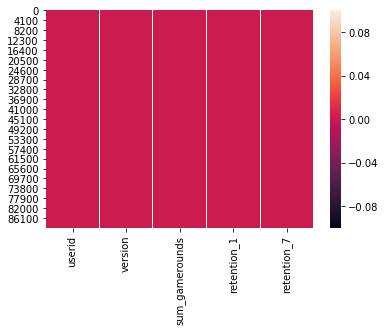

In [8]:
# check missing values
df.info()

sns.heatmap(df.isnull())


Both the summary and plot show that we do not have missing values in our dataset, which is good.

### Distribution of game version
Let's check the  values on each games version

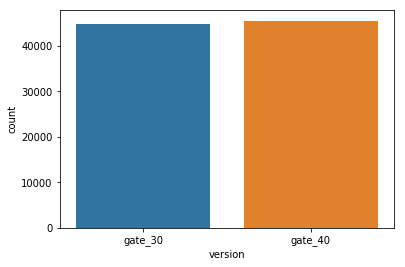

In [10]:
# count of values in each group
df.groupby('version').count()

# plot the count plot
sns.countplot(x = "version", data = df)

The numbers of users of version gate_30 and gate_40 are pretty much equal. 

### Distribution of game rounds vs number of users




In [154]:
df_plot = df.groupby('sum_gamerounds').count().reset_index()
df_plot.head()

,sum_gamerounds,userid,version,retention_1,retention_7
0,0,3994,3994,3994,3994
1,1,5538,5538,5538,5538
2,2,4606,4606,4606,4606
3,3,3958,3958,3958,3958
4,4,3629,3629,3629,3629


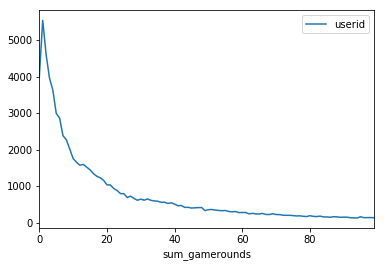

In [155]:
df_plot.head(n=100).plot(x = 'sum_gamerounds', y = 'userid')




In [163]:
## cut into groups
df_plot['group_rounds'] = pd.cut(df_plot['userid'], 4)
df_plot.groupby('group_rounds').count()

,sum_gamerounds,userid,version,retention_1,retention_7
group_rounds,,,,,
"(-4.537, 1385.25]",926,926,926,926,926
"(1385.25, 2769.5]",9,9,9,9,9
"(2769.5, 4153.75]",5,5,5,5,5
"(4153.75, 5538.0]",2,2,2,2,2


## 2. Data analysis

### Version vs sum_gamerounds

Let's explore what are the differences in total round of games between 2 versions of game

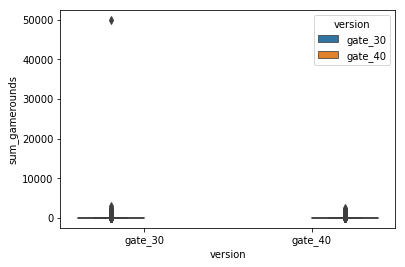

In [29]:
sns.boxplot(x = 'version', y = 'sum_gamerounds', hue = 'version', data = df )

Clearly to see, there is a big outlier in the game version 30. While major of users play less than 10000 rounds, 
there is one person who achives closely 5000 games. 

Let's remove the outliers and replot again. In additionm, since the scale of observations has big variation, I will use log scale to explore easier the relationship.

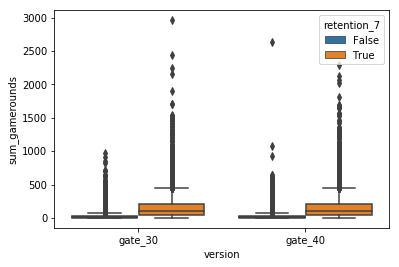

In [71]:
sns.boxplot(x = 'version', y = 'sum_gamerounds', hue = 'retention_7', data = df[df['sum_gamerounds'] < 4000])

Seems like in version 30, there are higher rounds that users play, and the ratio of number of people come back and play after one day is also higher.

Let's find the average of retention after 1 day in overall.

In [94]:
avg_1day = df['retention_1'].mean()
print('The percentage of users come back and play game (retention == True) after one day is:', round(avg_1day*100, 2), '%')

The percentage of users come back and play game (retention == True) after one day is: 44.52 %


In [97]:
avg_1day_group = df.groupby('version')['retention_1'].mean()
print('Average of users come back and play game in version 30 is:', round(avg_1day_group[0]*100, 2),'%')
print('Average of users come back and play game in version 40 is:', round(avg_1day_group[1]*100, 2),'%')

Average of users come back and play game in version 30 is: 44.82 %
Average of users come back and play game in version 40 is: 44.23 %


Based on the above, the retention of version 30 is slightly higher than version 30